# IMPORT LIBRARY YANG DIPERLUKAN

Pada tahap ini import library yang penting. untuk keperluan development model.

In [1]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.6 MB/s eta 0:00:00


In [4]:
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
import dill

# SETUP CONSTANTS

Dalam blok ini, kita mendefinisikan berbagai konstanta yang digunakan dalam proses pelatihan dan evaluasi model. Konstanta-konstanta ini meliputi path (lokasi direktori) untuk dataset, objek model, laporan pelatihan, serta hyperparameter penting seperti ukuran batch, jumlah epoch, ukuran gambar, dan parameter optimasi.

## function

In [5]:
def load_object(file_path):
    """
    Fungsi untuk memuat objek dari file dengan menggunakan modul `dill`.

    Args:
        file_path (str): Lokasi file dari objek yang ingin dimuat.

    Returns:
        object: Objek yang dimuat dari file.
    """

    try:
        with open(file_path, 'rb') as file_obj:
            return dill.load(file_obj)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

## main program

In [6]:
# ==========================================================================================
# ==================================== PARENT PATH CONSTANT ================================
# ==========================================================================================
PARENT_DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet"
DATA_PATH = os.path.join(PARENT_DATASET_PATH, "artifacts", "data")
OBJECT_PATH = os.path.join(PARENT_DATASET_PATH, "artifacts", "objects")
REPORT_PATH = os.path.join(PARENT_DATASET_PATH, "artifacts", "reports")



# ==========================================================================================
# ==================================== DATA PATH CONSTANT ==================================
# ==========================================================================================
TRAIN_TFRECOARD_PATH = os.path.join(DATA_PATH, "tfrecords", "train_trashnet.tfrecord")
VALID_TFRECORD_PATH = os.path.join(DATA_PATH, "tfrecords", "valid_trashnet.tfrecord")


# ==========================================================================================
# =============================== OBJECT PATH CONSTANT  ====================================
# ==========================================================================================
TARGET_KERAS_MODEL_PATH = os.path.join(OBJECT_PATH, "VGG16_model.keras")
LABEL_LIST_PATH = os.path.join(OBJECT_PATH, "label_list.pkl")


# ==========================================================================================
# =============================== HYPERPARAMETER CONSTANT  =================================
# ==========================================================================================
IMAGE_SIZE = (224, 224)

# PREDICTION

## function

In [7]:
def show_multiple_images_with_label_pred_tf_data(
    model,
    dataset,
    n_skip,
    num_images,
    figsize_per_image=(2, 2),
    classes_list=None
):
    """
    Menampilkan beberapa gambar dengan label dan prediksi model.
    Kode ini mendukung prediksi multiclass dan dapat bekerja dengan batch data.

    Args:
        model: Model machine learning yang digunakan untuk prediksi.
        dataset: Dataset TensorFlow dengan gambar dan label.
        n_skip: Jumlah gambar yang dilewatkan dalam dataset sebelum menampilkan.
        num_images: Jumlah gambar yang ingin ditampilkan.
        figsize_per_image: Ukuran tiap gambar dalam grid (default = (2, 2)).
        classes_list: Daftar label kelas untuk prediksi multiclass.
    """
    dataset = dataset.skip(n_skip).take(num_images)

    num_columns = math.ceil(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_columns)
    figsize = (num_columns * figsize_per_image[0], num_rows * figsize_per_image[1])

    plt.figure(figsize=figsize)

    for idx, (image, label) in enumerate(dataset):
        if len(image.shape) > 3:  # Jika bentuk batch data
            image = image[0]
            label = label[0]

        # Expand dims for prediction
        image_expanded = tf.expand_dims(image, axis=0)

        # Prediksi multiclass
        label_predictions = model.predict(image_expanded, verbose=0)
        label_predictions = tf.squeeze(label_predictions).numpy()

        if len(classes_list) > 2:  # Multiclass classification
            predicted_class_index = np.argmax(label_predictions)
            confidence = label_predictions[predicted_class_index] * 100  # Get confidence score
            alphabet_label_predictions = classes_list[predicted_class_index]
        else:  # Binary classification
            predicted_class_index = int(label_predictions > 0.5)
            confidence = label_predictions * 100 if predicted_class_index == 1 else (1 - label_predictions) * 100
            alphabet_label_predictions = classes_list[predicted_class_index]

        # Label asli
        alphabet_label_true = classes_list[label.numpy()]

        # Tampilkan gambar dengan prediksi, label asli, dan confidence score
        plt.subplot(num_rows, num_columns, idx + 1)
        plt.imshow(np.squeeze(image), cmap='gray')

        # Standar penulisan judul plot yang lebih profesional:
        plt.title(f"Image {idx+1} \nPred: {alphabet_label_predictions} ({confidence:.2f}%)\nTrue: {alphabet_label_true}", fontsize=8)
        plt.axis('off')

    plt.show()

## main program

### load model, dataset, dan label list

In [8]:
label_list = load_object(LABEL_LIST_PATH)
best_model = tf.keras.models.load_model(TARGET_KERAS_MODEL_PATH)
train_tf_dataset_loaded = tf.data.Dataset.load(TRAIN_TFRECOARD_PATH, compression="GZIP")
valid_tf_dataset_loaded = tf.data.Dataset.load(VALID_TFRECORD_PATH, compression="GZIP")

In [10]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,701,972 (59.90 MB)

 Trainable params: 329,094 (1.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 658,190 (2.51 MB)

### plot hasil prediksi data test

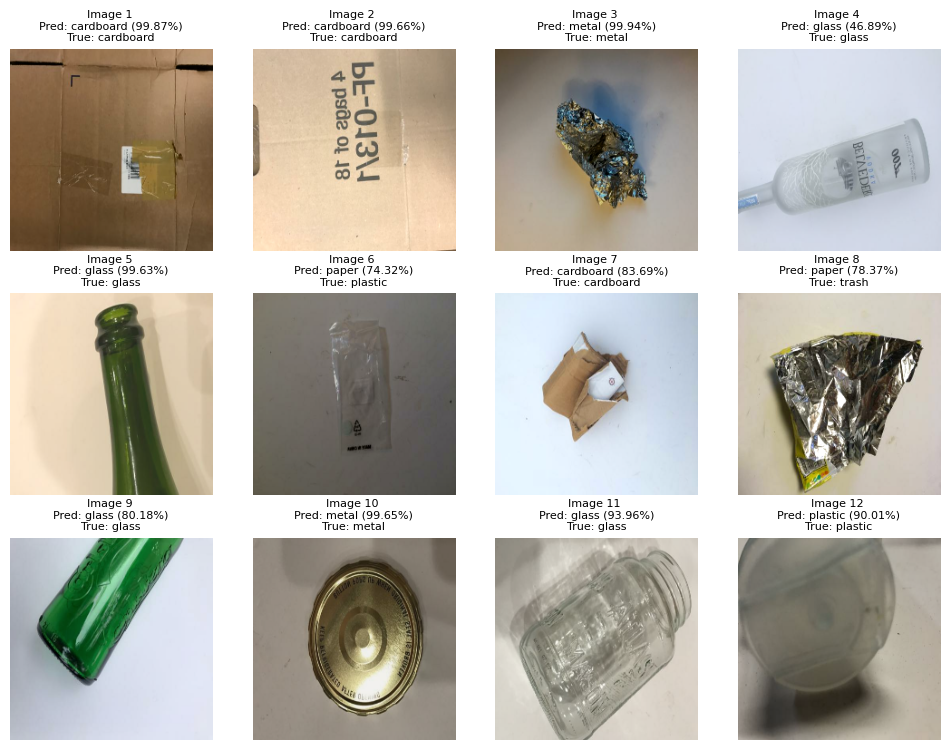

In [11]:
show_multiple_images_with_label_pred_tf_data(
  model=best_model,
  dataset=valid_tf_dataset_loaded,
  n_skip=1,
  num_images=12,
  figsize_per_image=(3, 3),
  classes_list=label_list
)

### plot hasil prediksi dari data eksternal

In [12]:
class ImagePreprocessor:
    def __init__(self, target_size=(240, 240), channels=3):
        """Inisialisasi preprocessor gambar dengan ukuran target."""
        self.target_size = target_size
        self.channels = channels

    def _resize_image(self, image):
        """Resize gambar input ke ukuran target."""
        return tf.image.resize(image, self.target_size)

    def _normalize_image(self, image):
        """Normalisasi gambar ke rentang [0, 1]."""
        image = tf.cast(image, tf.float32)
        image = image / 255.0
        return image

    def _augment_image(self, image):
        """Terapkan augmentasi pada gambar (misalnya flipping, rotation)."""
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image

    def preprocess(self, image, augment=False):
        """
        Lakukan preprocessing pada gambar, meliputi resize, normalisasi, dan augmentasi opsional.

        Args:
            image: Gambar input.
            augment: Flag untuk mengaktifkan augmentasi.

        Returns:
            Preprocessed image.
        """
        image = self._resize_image(image)
        if augment:
            image = self._augment_image(image)
        image = self._normalize_image(image)
        return image

    def prepare_for_model(self, image_input, augment=False, is_gray=False):
        """
        Persiapkan gambar untuk input model, bisa untuk batch atau single image.

        Args:
            image_input: Path ke gambar atau Tensor gambar.
            augment: Flag untuk mengaktifkan augmentasi.

        Returns:
            Gambar yang sudah di-preprocess dan siap untuk model.
        """
        # Cek apakah input adalah path atau Tensor
        if isinstance(image_input, str):
            # Load image dari path
            channels = 1 if is_gray else 3
            image = tf.io.read_file(image_input)
            image = tf.image.decode_image(image, channels=channels)
        else:
            # Jika input sudah dalam bentuk Tensor, gunakan langsung
            image = image_input

        # Preprocess image
        image = self.preprocess(image, augment)

        # Tambahkan dimensi batch jika diperlukan (untuk model prediction)
        image = tf.expand_dims(image, axis=0) if len(image.shape) == 3 else image
        return image

    def preprocess_batch(self, image_batch, augment=False):
        """
        Preprocessing untuk batch gambar, cocok untuk prediksi batch atau training.

        Args:
            image_batch: Batch gambar dalam bentuk Tensor.
            augment: Flag untuk mengaktifkan augmentasi.

        Returns:
            Batch gambar yang sudah di-preprocess.
        """
        # Proses tiap gambar dalam batch
        image_batch = tf.map_fn(lambda img: self.preprocess(img, augment), image_batch)
        return image_batch

In [13]:
def predict_image(model, processed_image, label_list, threshold=0.5):
    """
    Fungsi untuk melakukan prediksi gambar, mendukung binary dan multiclass classification.

    Args:
        model: Trained model untuk melakukan prediksi.
        processed_image: Gambar yang sudah dipreproses untuk input model.
        label_list: Daftar label untuk multiclass atau binary classification.
        threshold: Threshold untuk binary classification (default = 0.5).

    Returns:
        Predicted label (string) dari label_list.
    """
    predictions = model.predict(processed_image, verbose=0)
    predictions = tf.squeeze(predictions).numpy()

    if len(label_list) == 2:  # Binary classification
        predicted_label = label_list[int(predictions > threshold)]
    else:  # Multiclass classification
        predicted_label = label_list[np.argmax(predictions)]

    return predicted_label


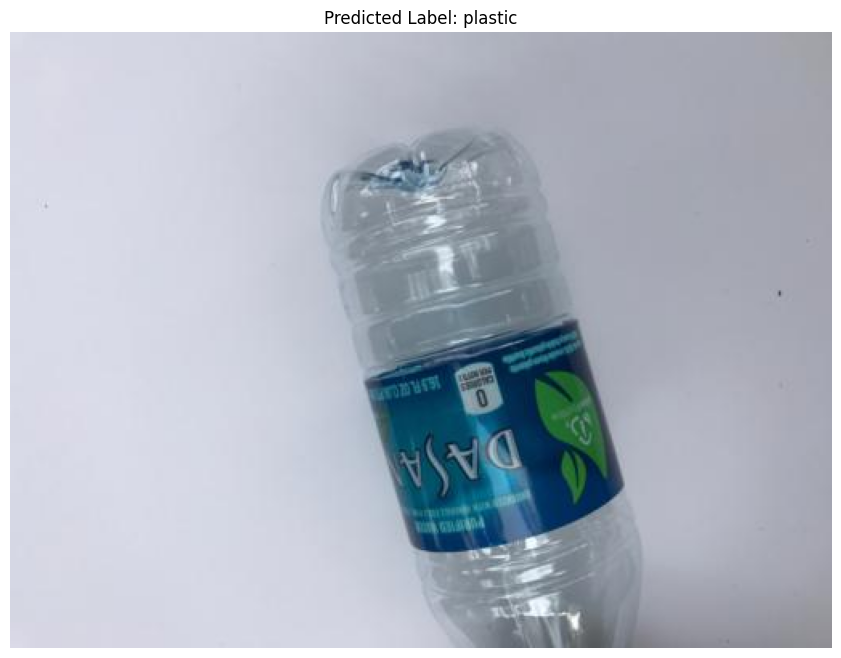

In [24]:
# Path gambar yang akan diproses
img_path = '/content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/data/data_sources/dataset-resized/plastic/plastic100.jpg'
image = Image.open(img_path)

preprocessor = ImagePreprocessor(target_size=(IMAGE_SIZE))
processed_image = preprocessor.prepare_for_model(img_path)
predicted_label = predict_image(best_model, processed_image, label_list)


plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')

plt.show()